2019-07-16

### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import *

### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('../dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

c_before = list(df.columns)

# Generate feats (train-test-same feats)
#create_feats(df)
df = create_dt_feats(df, 'txn_dt')
df = create_dt_feats(df, 'building_complete_dt')
df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
df['building_per_land_area'] = df['building_area'] / df['land_area']
df['height_r'] = df['txn_floor'] / df['total_floor']
df['top_floor'] = df['txn_floor'] == df['total_floor']

In [6]:
c_after = list(df.columns)

In [9]:
cols_num_add = [c for c in c_after if c not in c_before]
cols_num_add

['dow_txn_dt',
 'day_in_year_txn_dt',
 'month_txn_dt',
 'quarter_txn_dt',
 'year_txn_dt',
 'dow_building_complete_dt',
 'day_in_year_building_complete_dt',
 'month_building_complete_dt',
 'quarter_building_complete_dt',
 'year_building_complete_dt',
 'dt_diff_building_complete_dt_txn_dt',
 'building_per_land_area',
 'height_r',
 'top_floor']

In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]

In [11]:
cols_feats = cols_num + cols_cat + cols_bin

### Target transform

In [12]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price']/df['building_area'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred = pd.Series(y_pred.copy())
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    y_pred_final = y_pred_final * df['building_area'].reset_index(drop=True)
    return y_pred_final.values

In [13]:
df = target_transform(df)

In [14]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [15]:
from feature_engineering import CategoricalColumnsEncoder

In [16]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [17]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              #'feature_fraction': 1,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
             }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [18]:
%%time
feat_shuffle_results_dict = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    params = params_fix.copy()
    print('params:', params)

    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    
    for feat_name in ['none']+cols_feats:
        df_val_shuffle = df_val[cols_feats].copy()
        
        if feat_name != 'none':
            #if isinstance(df_val_shuffle[feat_name].dtype, pd.api.types.CategoricalDtype):
            dtype_col = df_val_shuffle[feat_name].dtype
            df_val_shuffle[feat_name] = np.random.permutation(df_val_shuffle[feat_name].values)
            df_val_shuffle[feat_name] = df_val_shuffle[feat_name].astype(dtype_col)
        
        y_pred = model.predict(df_val_shuffle)
        y_pred_final = target_inverse_transform(df_val, y_pred)
        score = cal_score(df_val['total_price'], y_pred_final)
        print('%10.5f'%score, feat_name)

        feat_shuffle_results_dict[feat_name] = feat_shuffle_results_dict.get(feat_name, []) + [score]

# aggregate, sort gsearch results
feat_shuffle_results = [[key, np.mean(val), val] for key, val in feat_shuffle_results_dict.items()]
feat_shuffle_results.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00984912
[4000]	valid_0's mape: 0.00974676
[6000]	valid_0's mape: 0.00972672
[8000]	valid_0's mape: 0.0097197
[10000]	valid_0's mape: 0.00971716
Did not meet early stopping. Best iteration is:
[9434]	valid_0's mape: 0.00971715
5612.86533 none
3935.79337 txn_dt
5094.85462 total_floor
3538.75414 building_complete_dt
5560.86439 parking_area
5341.85779 parking_price
4478.82279 txn_floor
4972.83846 land_area
5119.85229 building_area
5574.86293 lat
5406.85985 lon
5022.84996 village_income_median
5538.86344 town_population
5564.86440 town_area
5600.86459 town_population_density
5048.85448 doc_rate
5612.86514 master_rate
5612.86533 bachelor_rate
5567.86423 jobschool_rate
5617.86532 highschool_rate
5608.86528 junior_rate

5664.86641 XI_100
5649.86619 XI_250
5652.86625 XI_500
5532.86418 XI_1000
5655.86624 XI_5000
5658.86620 XI_10000
5658.86559 XI_MIN
5658.86635 XII_10
5656.86640 XII_50
5652.86629 XII_100
5651.86587 XII_250
5625.86533 XII_500
5604.86368 XII_1000
5621.86521 XII_5000
5649.86548 XII_10000
5640.86557 XII_MIN
5661.86643 XIII_10
5662.86642 XIII_50
5660.86642 XIII_100
5664.86628 XIII_250
5652.86635 XIII_500
5652.86620 XIII_1000
5407.86112 XIII_5000
2819.55798 XIII_10000
5646.86535 XIII_MIN
5662.86643 XIV_10
5658.86634 XIV_50
5651.86637 XIV_100
5655.86619 XIV_250
5659.86599 XIV_500
5646.86591 XIV_1000
5592.86402 XIV_5000
5639.86557 XIV_10000
5645.86581 XIV_MIN
5668.86637 dow_txn_dt
5656.86605 day_in_year_txn_dt
5661.86645 month_txn_dt
5662.86644 quarter_txn_dt
5644.86620 year_txn_dt
5634.86603 dow_building_complete_dt
5658.86598 day_in_year_building_complete_dt
5662.86644 month_building_complete_dt
5662.86644 quarter_building_complete_dt
5654.86587 year_building_complete_dt
5499.86321 dt_diff_bui

In [19]:
# aggregate, sort gsearch results
feat_shuffle_results = [[key, np.mean(val), val] for key, val in feat_shuffle_results_dict.items()]
feat_shuffle_results.sort(key= lambda x: x[1], reverse=True)

In [20]:
df_feat_shuffle_results = pd.DataFrame([row[0:2] + row[2] for row in feat_shuffle_results],
                                       columns=['col', 'mean', 'fold 1', 'fold 2', 'fold 3'])

In [82]:
for i in range(3):
    df_feat_shuffle_results['mape fold '+str(i+1)] = 1 - np.mod(df_feat_shuffle_results['fold '+str(i+1)], 1)
df_feat_shuffle_results['mape'] = df_feat_shuffle_results.loc[:, ['mape fold '+str(i+1) for i in range(3)]].mean(axis=1)

In [85]:
df_feat_shuffle_results.head(20)

,col,mean,fold 1,fold 2,fold 3,mape fold 1,mape fold 2,mape fold 3,mape
0,dow_txn_dt,5626.198100,5620.865261,5668.866368,5588.862670,0.134739,0.133632,0.137330,0.135233
1,X_100,5623.864822,5614.865302,5665.866410,5590.862753,0.134698,0.133590,0.137247,0.135178
2,N_500,5623.864780,5618.865226,5660.866398,5591.862715,0.134774,0.133602,0.137285,0.135220
3,VI_250,5623.531525,5618.865336,5662.866427,5588.862811,0.134664,0.133573,0.137189,0.135142
4,death_rate,5623.531508,5614.865324,5662.866429,5592.862769,0.134676,0.133571,0.137231,0.135159
5,elementary_rate,5623.531437,5610.865299,5665.866342,5593.862670,0.134701,0.133658,0.137330,0.135230
6,V_50,5623.198158,5612.865319,5666.866413,5589.862743,0.134681,0.133587,0.137257,0.135175
7,XI_index_1000,5622.864847,5612.865326,5664.866441,5590.862774,0.134674,0.133559,0.137226,0.135153
8,VI_index_500,5622.864846,5612.865328,5664.866436,5590.862773,0.134672,0.133564,0.137227,0.135154
9,XIV_10,5622.864841,5614.865324,5662.866427,5590.862771,0.134676,0.133573,0.137229,0.135159


In [22]:
# This is used for generating shuffle_result_per_area_new in vars_03.py 
display(feat_shuffle_results)

[['dow_txn_dt',
  5626.198099861352,
  [5620.865261231704, 5668.86636794657, 5588.862670405783]],
 ['X_100',
  5623.8648216837755,
  [5614.865301586619, 5665.866410357617, 5590.862753107089]],
 ['N_500',
  5623.86477971246,
  [5618.865225515247, 5660.8663982030175, 5591.862715419118]],
 ['VI_250',
  5623.531524725981,
  [5618.865335676486, 5662.866427357601, 5588.862811143857]],
 ['death_rate',
  5623.531507556135,
  [5614.865324125571, 5662.866429425544, 5592.8627691172915]],
 ['elementary_rate',
  5623.531436894802,
  [5610.865299249248, 5665.866341926721, 5593.862669508438]],
 ['V_50',
  5623.198158176917,
  [5612.865318566954, 5666.866413155236, 5589.86274280856]],
 ['XI_index_1000',
  5622.864846795162,
  [5612.865326000991, 5664.866440745881, 5590.862773638612]],
 ['VI_index_500',
  5622.8648455873445,
  [5612.865327961407, 5664.866435821978, 5590.86277297865]],
 ['XIV_10',
  5622.8648405979575,
  [5614.8653235067195, 5662.866427417328, 5590.862770869823]],
 ['V_10',
  5622.86483

In [23]:
scores_feat_rank = [row [1] for row in feat_shuffle_results if row[0] != 'none']

In [62]:
none_rank = df_feat_shuffle_results.loc[df_feat_shuffle_results['col']=='none'].index[0]
none_score = df_feat_shuffle_results.loc[none_rank, 'mean']
none_rank, none_score

(42, 5622.198178030939)

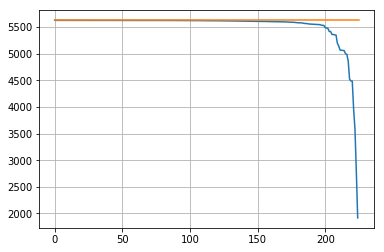

In [37]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [none_score, none_score])
#plt.xscale('log')
plt.grid()
plt.show()

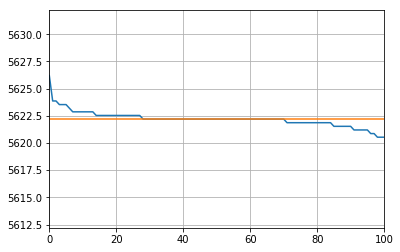

In [38]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [none_score, none_score])
plt.xlim(0, 100)
plt.ylim(none_score-10, none_score+10)
#plt.xscale('log')
plt.grid()
plt.show()

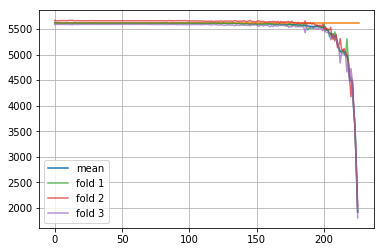

In [52]:
plt.plot(df_feat_shuffle_results['mean'], label='mean')
plt.plot([0, len(df_feat_shuffle_results)], [none_score, none_score])
plt.plot(df_feat_shuffle_results['fold 1'], label='fold 1', alpha=0.7)
plt.plot(df_feat_shuffle_results['fold 2'], label='fold 2', alpha=0.7)
plt.plot(df_feat_shuffle_results['fold 3'], label='fold 3', alpha=0.7)
#plt.xscale('log')
plt.grid(); plt.legend()
plt.show()

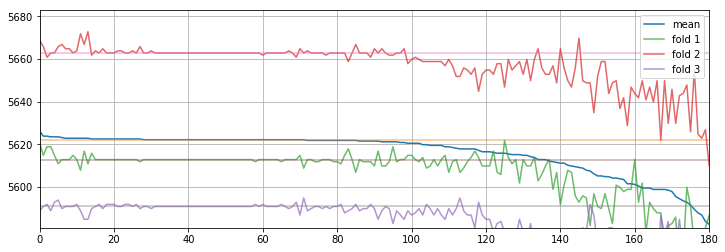

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(df_feat_shuffle_results['mean'], label='mean')
plt.plot([0, len(df_feat_shuffle_results)], [none_score, none_score], alpha=0.5)
plt.plot(df_feat_shuffle_results['fold 1'], label='fold 1', alpha=0.7)
plt.plot(df_feat_shuffle_results['fold 2'], label='fold 2', alpha=0.7)
plt.plot(df_feat_shuffle_results['fold 3'], label='fold 3', alpha=0.7)
none_fold_scores = []
for i in range(3):
    none_fold_scores.append(df_feat_shuffle_results.loc[none_rank, 'fold '+str(i+1)])
    plt.plot([0, len(df_feat_shuffle_results)], [none_fold_scores[i]]*2, alpha=0.5)
plt.xlim(0, 180); plt.ylim(min(none_fold_scores)-10, max(none_fold_scores)+20)
plt.grid(); plt.legend()
plt.show()

In [71]:
# Additional features that increase in score in single fold when shuffle
additional_list = []
for i in range(3):
    none_fold_score = df_feat_shuffle_results.loc[none_rank, 'fold '+str(i+1)]
    additional_list.append(df_feat_shuffle_results.loc[
        (df_feat_shuffle_results['fold '+str(i+1)] > none_fold_score)
        & (df_feat_shuffle_results.index > none_rank), 
        'col'].tolist())
    print(i, additional_list[i])

0 ['XI_index_5000', 'VIII_index_1000', 'VI_10', 'X_10', 'XI_index_50', 'VII_index_50', 'XI_100', 'IX_10', 'II_index_500', 'XIII_50', 'highschool_rate', 'IX_100', 'V_100', 'I_250', 'III_100', 'II_50', 'X_250', 'XI_500', 'VIII_10000', 'year_txn_dt', 'XIII_1000', 'XIII_MIN', 'III_1000', 'V_500']
1 ['VIII_index_1000', 'VI_50', 'XI_10', 'XI_index_500', 'VIII_index_500', 'VIII_index_50', 'IV_index_5000', 'V_index_50', 'XI_100', 'IX_10', 'II_index_500', 'N_5000', 'VI_1000', 'IV_index_1000', 'N_10000', 'IX_50', 'XIII_250', 'VII_100', 'VIII_100', 'IV_5000']
2 ['VI_50', 'VI_10', 'III_index_1000', 'XI_10', 'XI_index_500', 'X_index_50', 'IV_index_50', 'XIII_10', 'I_index_50', 'V_index_1000', 'XIII_100', 'junior_rate', 'IV_index_500', 'IV_50', 'VI_1000', 'IX_index_50', 'II_100', 'VI_500', 'year_txn_dt', 'III_10000']


In [80]:
print(list(set(sum(additional_list, []))))

['VIII_index_50', 'VIII_100', 'XIII_250', 'VI_500', 'III_100', 'IV_index_500', 'IV_index_50', 'VII_100', 'XI_index_500', 'II_50', 'IX_10', 'IX_100', 'IV_index_5000', 'XI_index_50', 'XI_500', 'XI_index_5000', 'VIII_index_500', 'III_1000', 'XIII_100', 'XI_100', 'IX_50', 'VIII_10000', 'XIII_1000', 'IX_index_50', 'I_250', 'V_500', 'III_index_1000', 'VI_10', 'XIII_MIN', 'X_10', 'XI_10', 'II_100', 'year_txn_dt', 'II_index_500', 'VIII_index_1000', 'I_index_50', 'XIII_50', 'N_5000', 'XIII_10', 'V_index_1000', 'VII_index_50', 'N_10000', 'junior_rate', 'X_250', 'VI_50', 'V_index_50', 'IV_index_1000', 'IV_50', 'IV_5000', 'V_100', 'III_10000', 'highschool_rate', 'VI_1000', 'X_index_50']


#### MAPE ordered

In [88]:
df_feat_shuffle_results_mape = df_feat_shuffle_results.sort_values('mape').reset_index(drop=True)

In [96]:
df_feat_shuffle_results_mape.head(20)

,col,mean,fold 1,fold 2,fold 3,mape fold 1,mape fold 2,mape fold 3,mape
0,VI_250,5623.531525,5618.865336,5662.866427,5588.862811,0.134664,0.133573,0.137189,0.135142
1,month_txn_dt,5622.531518,5615.865326,5661.866447,5589.862780,0.134674,0.133553,0.137220,0.135149
2,XI_index_1000,5622.864847,5612.865326,5664.866441,5590.862774,0.134674,0.133559,0.137226,0.135153
3,VII_index_500,5622.198180,5612.865333,5662.866436,5590.862771,0.134667,0.133564,0.137229,0.135153
4,IX_10,5621.864846,5612.865329,5663.866435,5588.862774,0.134671,0.133565,0.137226,0.135154
5,III_index_50,5622.531513,5612.865328,5663.866438,5590.862772,0.134672,0.133562,0.137228,0.135154
6,XIII_index_50,5622.531512,5612.865326,5662.866436,5591.862775,0.134674,0.133564,0.137225,0.135154
7,V_index_500,5622.198179,5612.865328,5662.866437,5590.862772,0.134672,0.133563,0.137228,0.135154
8,VI_index_500,5622.864846,5612.865328,5664.866436,5590.862773,0.134672,0.133564,0.137227,0.135154
9,XII_index_50,5622.531512,5612.865326,5664.866439,5589.862772,0.134674,0.133561,0.137228,0.135154


In [97]:
none_mape_rank = df_feat_shuffle_results_mape.loc[df_feat_shuffle_results_mape['col']=='none'].index[0]
none_mape = df_feat_shuffle_results_mape.loc[none_mape_rank, 'mape']
none_mape_rank, none_mape

(26, 0.13515530239419604)

In [92]:
display(df_feat_shuffle_results_mape[['col', 'mape']].values.tolist())

[['VI_250', 0.135141940685268],
 ['month_txn_dt', 0.13514888447934936],
 ['XI_index_1000', 0.13515320483838877],
 ['VII_index_500', 0.1351533922146094],
 ['IX_10', 0.13515396295618606],
 ['III_index_50', 0.13515404581600401],
 ['XIII_index_50', 0.13515433692343018],
 ['V_index_500', 0.13515440137446907],
 ['VI_index_500', 0.13515441265493186],
 ['XII_index_50', 0.13515442593810198],
 ['III_10', 0.13515443472503344],
 ['X_index_500', 0.13515464098266725],
 ['IX_index_1000', 0.13515477366551445],
 ['quarter_txn_dt', 0.13515478140258588],
 ['I_10', 0.1351548411321346],
 ['III_index_500', 0.13515487878733742],
 ['I_index_1000', 0.13515493442779794],
 ['XIII_index_5000', 0.1351549657229043],
 ['XII_index_500', 0.1351550048999949],
 ['II_index_500', 0.13515511228858182],
 ['X_index_1000', 0.13515514202633008],
 ['IV_index_500', 0.1351551878663789],
 ['VII_index_1000', 0.13515524465189324],
 ['bachelor_rate', 0.13515526101461242],
 ['IX_index_500', 0.13515527361626786],
 ['month_building_comp

## Feature remove

### Feature remove list 1
Remove feature with shuffle scores >= non-shuffle score

In [41]:
feat_rm_1 = [c for c in df_feat_shuffle_results.loc[df_feat_shuffle_results['mean'] >= none_score, 'col'].tolist() if c != 'none']

In [42]:
print(len(feat_rm_1))
print('feat_rm_1 =', feat_rm_1)

47
feat_rm_1 = ['dow_txn_dt', 'X_100', 'N_500', 'VI_250', 'death_rate', 'elementary_rate', 'V_50', 'XI_index_1000', 'VI_index_500', 'XIV_10', 'V_10', 'IV_500', 'IV_250', 'III_5000', 'month_txn_dt', 'III_index_50', 'XIII_index_50', 'XII_index_50', 'I_index_1000', 'X_index_1000', 'II_index_50', 'II_10', 'VI_index_50', 'XIII_index_1000', 'XIII_index_10000', 'XIV_index_50', 'X_50', 'VII_10', 'VII_index_500', 'V_index_500', 'III_10', 'X_index_500', 'IX_index_1000', 'quarter_txn_dt', 'I_10', 'III_index_500', 'XIII_index_5000', 'XII_index_500', 'VII_index_1000', 'bachelor_rate', 'IX_index_500', 'month_building_complete_dt', 'top_floor', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000']


### Feature remove list 2
Remove feature with shuffle scores less then none_score - 1

In [45]:
feat_rm_2 = [c for c in df_feat_shuffle_results.loc[df_feat_shuffle_results['mean'] >= none_score-0.5, 'col'].tolist()
             if c != 'none']

In [46]:
print(len(feat_rm_2))
print('feat_rm_2 =', feat_rm_2)

85
feat_rm_2 = ['dow_txn_dt', 'X_100', 'N_500', 'VI_250', 'death_rate', 'elementary_rate', 'V_50', 'XI_index_1000', 'VI_index_500', 'XIV_10', 'V_10', 'IV_500', 'IV_250', 'III_5000', 'month_txn_dt', 'III_index_50', 'XIII_index_50', 'XII_index_50', 'I_index_1000', 'X_index_1000', 'II_index_50', 'II_10', 'VI_index_50', 'XIII_index_1000', 'XIII_index_10000', 'XIV_index_50', 'X_50', 'VII_10', 'VII_index_500', 'V_index_500', 'III_10', 'X_index_500', 'IX_index_1000', 'quarter_txn_dt', 'I_10', 'III_index_500', 'XIII_index_5000', 'XII_index_500', 'VII_index_1000', 'bachelor_rate', 'IX_index_500', 'month_building_complete_dt', 'top_floor', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'XI_index_5000', 'VIII_index_1000', 'VI_50', 'VI_10', 'XIV_index_500', 'X_10', 'III_index_1000', 'XI_10', 'XI_index_500', 'XI_index_50', 'X_index_50', 'IV_index_50', 'XIII_10', 'VII_index_50', 'VIII_index_500', 'VIII_index_50', 'IV_index_5000', 'I_index_50', 'VI_100', 'V_index_50', 'V_index

### Feature remove list 3
Remove feature with shuffle scores last 100

In [47]:
feat_rm_3 = [c for c in df_feat_shuffle_results['col'].tolist()[:101] if c != 'none']

In [48]:
print(len(feat_rm_3))
print('feat_rm_3 =', feat_rm_3)

100
feat_rm_3 = ['dow_txn_dt', 'X_100', 'N_500', 'VI_250', 'death_rate', 'elementary_rate', 'V_50', 'XI_index_1000', 'VI_index_500', 'XIV_10', 'V_10', 'IV_500', 'IV_250', 'III_5000', 'month_txn_dt', 'III_index_50', 'XIII_index_50', 'XII_index_50', 'I_index_1000', 'X_index_1000', 'II_index_50', 'II_10', 'VI_index_50', 'XIII_index_1000', 'XIII_index_10000', 'XIV_index_50', 'X_50', 'VII_10', 'VII_index_500', 'V_index_500', 'III_10', 'X_index_500', 'IX_index_1000', 'quarter_txn_dt', 'I_10', 'III_index_500', 'XIII_index_5000', 'XII_index_500', 'VII_index_1000', 'bachelor_rate', 'IX_index_500', 'month_building_complete_dt', 'top_floor', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'XI_index_5000', 'VIII_index_1000', 'VI_50', 'VI_10', 'XIV_index_500', 'X_10', 'III_index_1000', 'XI_10', 'XI_index_500', 'XI_index_50', 'X_index_50', 'IV_index_50', 'XIII_10', 'VII_index_50', 'VIII_index_500', 'VIII_index_50', 'IV_index_5000', 'I_index_50', 'VI_100', 'V_index_50', 'V_inde

### Feature shuffle importance 

In [49]:
feat_rank_list = [c for c in df_feat_shuffle_results['col'].tolist() if c != 'none'];
print('feat_rank_list =', feat_rank_list)  # List of least important features

feat_rank_list = ['dow_txn_dt', 'X_100', 'N_500', 'VI_250', 'death_rate', 'elementary_rate', 'V_50', 'XI_index_1000', 'VI_index_500', 'XIV_10', 'V_10', 'IV_500', 'IV_250', 'III_5000', 'month_txn_dt', 'III_index_50', 'XIII_index_50', 'XII_index_50', 'I_index_1000', 'X_index_1000', 'II_index_50', 'II_10', 'VI_index_50', 'XIII_index_1000', 'XIII_index_10000', 'XIV_index_50', 'X_50', 'VII_10', 'VII_index_500', 'V_index_500', 'III_10', 'X_index_500', 'IX_index_1000', 'quarter_txn_dt', 'I_10', 'III_index_500', 'XIII_index_5000', 'XII_index_500', 'VII_index_1000', 'bachelor_rate', 'IX_index_500', 'month_building_complete_dt', 'top_floor', 'IX_index_5000', 'XI_index_10000', 'XII_index_1000', 'XIV_index_1000', 'XI_index_5000', 'VIII_index_1000', 'VI_50', 'VI_10', 'XIV_index_500', 'X_10', 'III_index_1000', 'XI_10', 'XI_index_500', 'XI_index_50', 'X_index_50', 'IV_index_50', 'XIII_10', 'VII_index_50', 'VIII_index_500', 'VIII_index_50', 'IV_index_5000', 'I_index_50', 'VI_100', 'V_index_50', 'V_ind